Occasionally, our measures for model accuracy can be misleading. This typically occurs when our model fitting overly-generalizes to whatever data it was trained on, and the way we split out train/test sets don't do a very good job of exposing the oversight.

To this end, we employ Validation Sets-- data held out of our Training Sets-- to approximate our Test Error.

## Sample Model

Before we get started, let's make our work reproducible.

In [1]:
%pylab inline

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


Now let's build a model

In [2]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

We're going to deliberately make a lopsided balance between how much of our data is training and how much is test.

In [3]:
def make_data():
    X, y = make_regression(n_informative=10, n_features=20,
                       n_samples=1000, noise=2)

    return train_test_split(X, y, test_size=.01)

In [4]:
train_X, test_X, train_y, test_y = make_data()
[arr.shape for arr in make_data()]

[(990, 20), (10, 20), (990,), (10,)]

And build a Decision Tree on top of it

In [5]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()

model.fit(train_X, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

### Evaluating the Model

And if we revisit the Root Mean Squared Error as our measure of model accuracy, we see that this is perhaps a respectable level of error.

In [6]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_y, model.predict(test_X))
rmse = np.sqrt(mse)
rmse

200.2823964921704

However, looking at the distribution of predictions vs actuals, we can see that a lot of this error comes a few points in `y_train`.

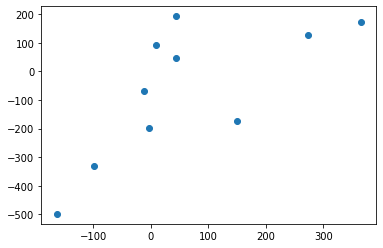

In [7]:
plt.scatter(model.predict(test_X), test_y);

The model was fit to predict on a target distribution that looked basically normal

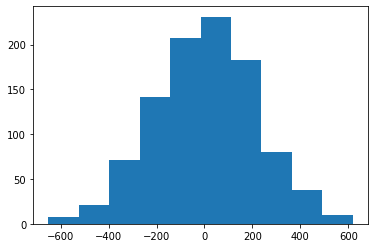

In [8]:
plt.hist(train_y);

by the (bad) luck of sampling, the 1% of `y` that made up `test_y` didn't really look like that at all.

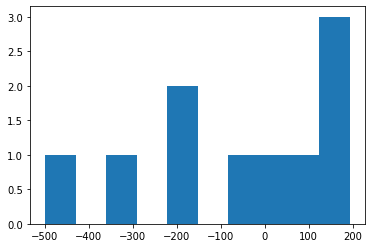

In [9]:
plt.hist(test_y);

So how do we ensure that we don't get "gotcha'd" when the distribution/variation of the 1% we held out isn't accurately captured by our training set?

## Cross-Validation

Cross-Validation involves a *second* splitting step after you've removed your Test data from your starting population.

By training then scoring on this intermediate set of data before checking your Test accuracy, you have more information about the performance of your model.

Moreover, when used to direct training/hyperparameter search, withholding your data helps correct overfitting during training.

### Validation Set

And so we'll further split our Training dataset

In [10]:
train_X.shape, train_y.shape

((990, 20), (990,))

A third will now be used for Validation

In [11]:
train_X, test_X, train_y, test_y = make_data()

train_X, validation_X, train_y, validation_y = train_test_split(train_X, train_y, test_size=.33)

In [12]:
train_X.shape, train_y.shape

((663, 20), (663,))

In [13]:
validation_X.shape, validation_y.shape

((327, 20), (327,))

In [14]:
test_X.shape, test_y.shape

((10, 20), (10,))

Refitting the model with the Validation records omitted

In [15]:
model = DecisionTreeRegressor()

model.fit(train_X, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

And our performance on the Validation set is about 60 points better than our last test!

In [16]:
mse = mean_squared_error(validation_y, model.predict(validation_X))
rmse = np.sqrt(mse)
rmse

143.2710672835756

Indeed, our model happens to be less overfit this time around.

In [17]:
mse = mean_squared_error(test_y, model.predict(test_X))
rmse = np.sqrt(mse)
rmse

168.02073456013332

But the fact that our Validation MSE wound up being lower than our Test MSE was completely arbitrary, another consequence of the random sample.

Indeed, in Chapter 5 ISL uses multiple Validation sets to determine what the appropriate Polynomial Degree is for a simulated regression problem. The *True* Test Error is shown in the left chart, but the right chart demonstrates that your MSE can vary wildly by the sheer luck of how you sampled your data-- though generally moving the same way as the Degree increases.

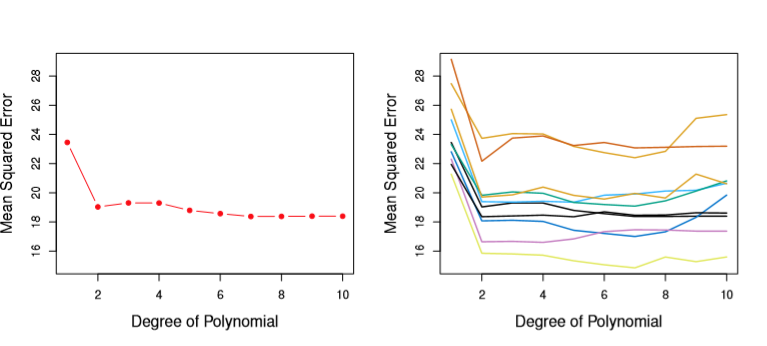

In [18]:
from IPython.display import Image

Image('images/diff_val_sets.PNG')

### K-Fold Cross-Validation

What we want to do instead is repeat that test/train splitting process across *multiple* samples of data within our dataset.

We do this with K-Fold Cross Validation, which splits the dataset up into `k` sets, then trains on `k-1` of them, testing against the holdout, ultimately returning each accuracy score.

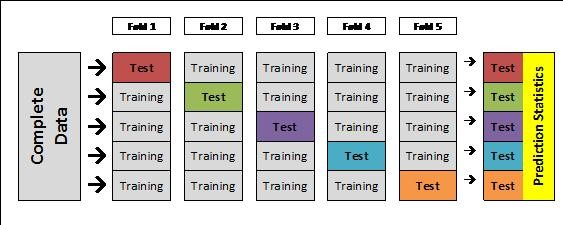

In [19]:
Image('images/crossval.jpg')

In [20]:
model = DecisionTreeRegressor()

In [21]:
train_X, test_X, train_y, test_y = make_data()

In [22]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(# what model we use
                         model,
                         # data we'll feed it
                         train_X,
                         train_y, 
                         # how we score each split
                         scoring='neg_mean_squared_error',
                         # how many cuts to make
                         cv=10)

accuracies = np.sqrt(-scores)
accuracies

array([ 92.59567985, 106.70686122, 111.12034656, 100.3642714 ,
        90.38853955,  94.77325883,  85.00335984,  97.94133301,
        98.682085  ,  98.72319924])

As we can see, there's still a good amount of variation depending on which slice of data we were testing against.

In [23]:
accuracies.std()

7.208537550908835

Therefore, we'll average out all of the cross-validation scores to get a more stable estimate.

In [24]:
accuracies.mean()

97.62989345115201

Effectively, taking these `k` different looks at our data means that *our model has been evaluated in against every point in our training set*. Thus when we read an MSE of `97.63`, we don't have to worry about whether or not we scored on some fringe part of the distribution or that we overfit.

Indeed, more-sophisticated approaches to Machine Learning leverage K-fold Cross Validation as an intermediate training step, the algorithm proceeds in the direction that minimizes the Cross Validation Error, then redefines the folds to prevent overfitting.